In [1]:
import numpy as np
import pandas as pd
df = pd.read_excel('respuestas_cuestionario.xlsx')

# 1. Codificación correcta: género binario (ignorando "Otro" que no aparece), residencia como one-hot, frecuencia como ordinal
df['genero'] = df['genero'].map({'Hombre': 0, 'Mujer': 1})

# Verificación de valores únicos antes de codificar la frecuencia
actividad_map = {
    'Solo en fiestas o vacaciones': 0,
    'De vez en cuando': 1,
    'Varias veces por semana': 2,
    'A diario': 3
}
df['actividad_frecuencia'] = df['actividad_frecuencia'].map(actividad_map)

# One-hot encoding para residencia (no ordinal)
residencia_dummies = pd.get_dummies(df['residencia'], prefix='residencia')

def expandir_recomendaciones(columna):
    actividades = [
        "Naturaleza y paseos", "Rutas", "Monumentos o historia",
        "Sitios tranquilos para descansar", "Eventos o fiestas",
        "Bares y restaurantes"
    ]
    resultado = pd.DataFrame(0, index=df.index, columns=[f"{columna}_{a}" for a in actividades])
    for i, respuesta in enumerate(df[columna].fillna('')):
        for actividad in actividades:
            if actividad in respuesta:
                resultado.at[i, f"{columna}_{actividad}"] = 1
    return resultado
recom_cols = ['recom_familias', 'recom_jovenes', 'recom_mayores']
recomendaciones_expandidas = pd.concat([expandir_recomendaciones(c) for c in recom_cols], axis=1)
X = pd.concat([
    df[['edad', 'genero', 'actividad_frecuencia', 'freq_recom']],
    residencia_dummies,
    recomendaciones_expandidas
], axis=1)

valoraciones_cols = [col for col in df.columns if col.startswith("valoracion_")]
Y = df[valoraciones_cols].applymap(lambda x: 1 if x >= 4 else 0)

C:\Users\jorge\AppData\Local\Temp\ipykernel_10840\505607549.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Y = df[valoraciones_cols].applymap(lambda x: 1 if x >= 4 else 0)


In [3]:
# 1. División de datos
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. Ponderación adicional para residentes permanentes
# Asignamos peso 1.5 a los residentes permanentes y 1 al resto
sample_weights = np.where(X_train['residencia_Sí, todo el año'] == 1, 1.5, 1.0)

# 3. Entrenar XGBoost (MultiOutput)
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Estimador base XGBoost
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

# MultiOutput wrapper
multi_xgb = MultiOutputClassifier(xgb, n_jobs=-1)


# 4. Grid Search de hiperparámetros
param_grid = {
    "estimator__n_estimators": [100, 200, 300],
    "estimator__max_depth": [3, 5, 7],
    "estimator__learning_rate": [0.05, 0.1, 0.2],
    "estimator__subsample": [0.8, 1.0],
    "estimator__colsample_bytree": [0.8, 1.0]
}

# 1. GridSearch sin sample_weight
grid_search_xgb = GridSearchCV(
    multi_xgb,
    param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)
grid_search_xgb.fit(X_train, Y_train)

print("Mejores hiperparámetros XGBoost:", grid_search_xgb.best_params_)

# 2. Entrenar el mejor modelo con sample_weight
best_xgb = grid_search_xgb.best_estimator_
for estimator in best_xgb.estimators_:
    estimator.set_params(**grid_search_xgb.best_params_)

# Reentrenar cada estimador con sample_weight
for i, col in enumerate(Y_train.columns):
    best_xgb.estimators_[i].fit(X_train, Y_train[col], sample_weight=sample_weights)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejores hiperparámetros XGBoost: {'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.05, 'estimator__max_depth': 3, 'estimator__n_estimators': 100, 'estimator__subsample': 1.0}


C:\Users\jorge\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__n_estimators", "estimator__subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\jorge\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__n_estimators", "estimator__subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\jorge\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:39:40] WARNIN

In [4]:
# 4. Evaluación
Y_pred_xgb = best_xgb.predict(X_test)
print("Reporte de clasificación (XGBoost):\n")
print(classification_report(Y_test, Y_pred_xgb, target_names=Y.columns))

Reporte de clasificación (XGBoost):

                                         precision    recall  f1-score   support

    valoracion_IglesiaSantoDomingoSilos       0.46      0.55      0.50        11
        valoracion_PanteonMarquesesMoya       0.60      0.69      0.64        13
              valoracion_CastilloAliaga       0.25      0.20      0.22         5
                valoracion_LagunaCaolin       0.38      0.60      0.46         5
          valoracion_RiberaRioGuadazaon       0.55      0.85      0.67        13
                valoracion_CerritoArena       0.39      0.78      0.52         9
                 valoracion_MiradorCruz       0.71      0.86      0.77        14
             valoracion_FuenteTresCanos       0.59      0.83      0.69        12
   valoracion_PuenteCristinasRioCabriel       0.77      1.00      0.87        17
valoracion_TorcasPalancaresTierraMuerta       0.79      0.94      0.86        16
           valoracion_LagunasCanadaHoyo       0.81      1.00      0.89 

C:\Users\jorge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


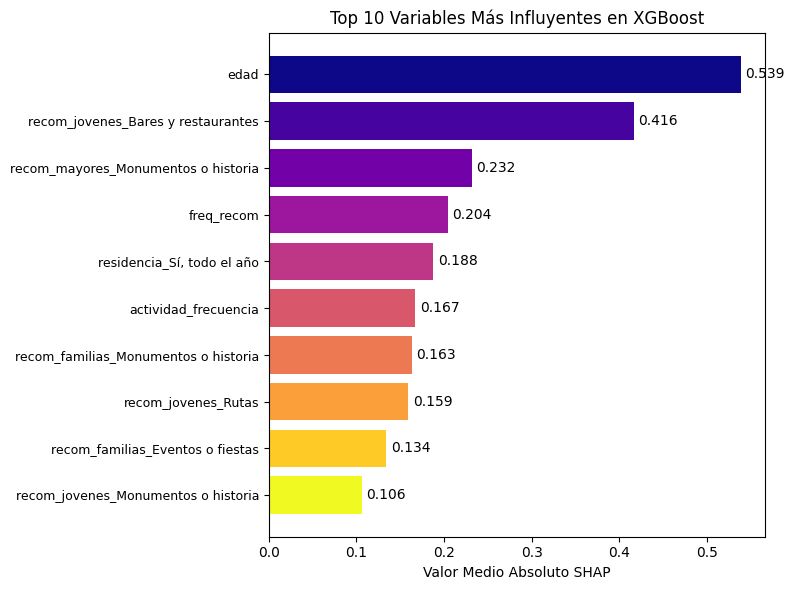

edad                                    0.538640
recom_jovenes_Bares y restaurantes      0.416438
recom_mayores_Monumentos o historia     0.232054
freq_recom                              0.204431
residencia_Sí, todo el año              0.187693
actividad_frecuencia                    0.167077
recom_familias_Monumentos o historia    0.163453
recom_jovenes_Rutas                     0.159302
recom_familias_Eventos o fiestas        0.133983
recom_jovenes_Monumentos o historia     0.106143
Name: mean_abs_shap, dtype: float64


In [19]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Carpeta de salida
os.makedirs("shap_plots_xgb", exist_ok=True)

# DataFrame para acumular las importancias globales
importancias_globales = pd.DataFrame(0, index=X_train.columns, columns=["mean_abs_shap"])

# Recorremos todos los modelos del MultiOutputClassifier
for idx, modelo in enumerate(best_xgb.estimators_):
    explainer = shap.TreeExplainer(modelo)
    shap_values = explainer.shap_values(X_train)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    importancias_globales["mean_abs_shap"] += mean_abs_shap

# Hacemos la media entre todos los modelos
importancias_globales["mean_abs_shap"] /= len(best_xgb.estimators_)

# Ordenamos de mayor a menor
importancias_globales = importancias_globales.sort_values(by="mean_abs_shap", ascending=False)

# Seleccionamos el Top 10
top_n = 10
top_features = importancias_globales.head(top_n)["mean_abs_shap"]

# Crear un gráfico horizontal con colores tipo plasma (igual que RF)
colors = plt.cm.plasma(np.linspace(0, 1, top_n))
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.barh(range(top_n), top_features.values[::-1], color=colors[::-1])
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features.index[::-1], fontsize=9)
ax.set_xlabel("Valor Medio Absoluto SHAP")
ax.set_title("Top 10 Variables Más Influyentes en XGBoost")

# Etiquetas al final de cada barra
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.005, bar.get_y() + bar.get_height()/2,
            f"{width:.3f}", va='center')

plt.tight_layout()
plt.savefig("shap_plots_xgb/shap_importancia_global_formato_RF.png", dpi=300, bbox_inches='tight')
plt.show()

print(top_features)

In [21]:
import shap
import matplotlib.pyplot as plt
import os
import numpy as np

# Carpeta para guardar las imágenes
os.makedirs("shap_plots_xgb", exist_ok=True)

# Ubicaciones a analizar
ubicaciones = ["valoracion_PuenteCristinasRioCabriel", "valoracion_CastilloAliaga"]

for ubicacion in ubicaciones:
    # Seleccionar el índice del modelo asociado a la ubicación
    idx = list(Y_train.columns).index(ubicacion)
    modelo = best_xgb.estimators_[idx]

    # Crear el explicador SHAP para el modelo individual
    explainer = shap.TreeExplainer(modelo)
    shap_values = explainer.shap_values(X_train)

    # 1. Gráfico de summary plot (dispersión)
    plt.figure()
    shap.summary_plot(shap_values, X_train, show=False)
    plt.title(f"Gráfico SHAP resumen - {ubicacion}")
    plt.tight_layout()
    plt.savefig(f"shap_plots_xgb/shap_summary_{ubicacion}.png", dpi=300, bbox_inches="tight")
    plt.close()

    # 2. Gráfico de dependencia para la variable edad
    plt.figure()
    shap.dependence_plot(
        "edad", shap_values, X_train,
        interaction_index="freq_recom",  # Color por freq_recom
        show=False
    )
    plt.title(f"Dependencia SHAP (edad) - {ubicacion}")
    plt.tight_layout()
    plt.savefig(f"shap_plots_xgb/shap_dependencia_edad_{ubicacion}.png", dpi=300, bbox_inches="tight")
    plt.close()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>